Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
root_path = '/content/gdrive/My Drive/Malenoma_Detection/'
#os.chdir(root_path)
#!unzip CNN_assignment_Malenoma.zip

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [58]:
# Defining the path for train and test images
## Update the paths of the train and test dataset
data_dir_train = pathlib.Path(root_path+"Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path(root_path+"Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

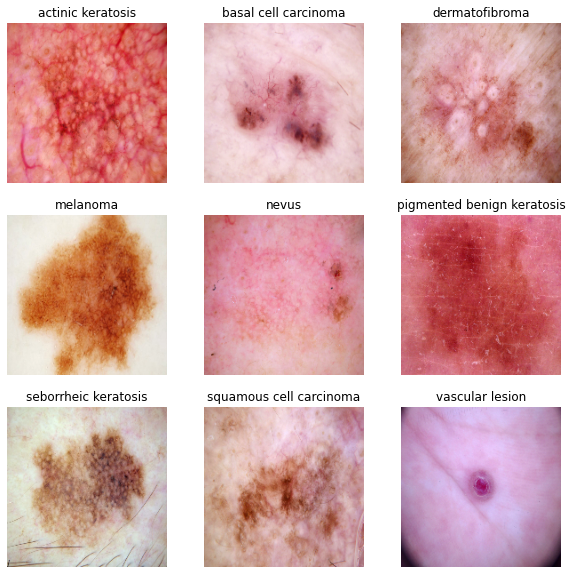

In [13]:
import matplotlib.pyplot as plt
from PIL import Image

images,labels = next(iter(train_ds))

def get_image_with_label(images,labels,val):
  for i in range(0,len(labels)-1):
    if( labels[i] == val ):
      img = tf.keras.preprocessing.image.array_to_img(images[i])
      return img
  images,labels = next(iter(train_ds))
  return get_image_with_label(images,labels,val)

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  img1 = get_image_with_label(images,labels,i)
  plt.title(class_names[i])
  plt.imshow(img1)
  plt.axis('off')

In [14]:
print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
num_classes = 9 
model = Sequential([
                    layers.Rescaling(scale=1./255,input_shape = (180,180,3)),
                    layers.Conv2D(16,3,padding='same',activation='relu'),
                    layers.MaxPool2D(pool_size=(2,2)),
                    layers.Conv2D(32,3,padding='same',activation='relu'),
                    layers.MaxPool2D(pool_size=2,strides=2),
                    layers.Flatten(),
                    layers.Dense(128,activation='relu'),
                    layers.Dense(num_classes,activation='softmax')
                    ])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [18]:
### choose an appropirate optimiser and loss function
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64800)             0

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 304s 1s/step - loss: 2.4468 - accuracy: 0.2137 - val_loss: 1.9590 - val_accuracy: 0.3020
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.7415 - accuracy: 0.3956 - val_loss: 1.5844 - val_accuracy: 0.5056
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5242 - accuracy: 0.4911 - val_loss: 1.4215 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4392 - accuracy: 0.4866 - val_loss: 1.6569 - val_accuracy: 0.3915
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3055 - accuracy: 0.5586 - val_loss: 1.4803 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2057 - accuracy: 0.5787 - val_loss: 1.4774 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1103 - accuracy: 0.6038 - val_loss: 1.3942 - val_accuracy: 0.5526
Epoch 8/20
56

### Visualizing training results

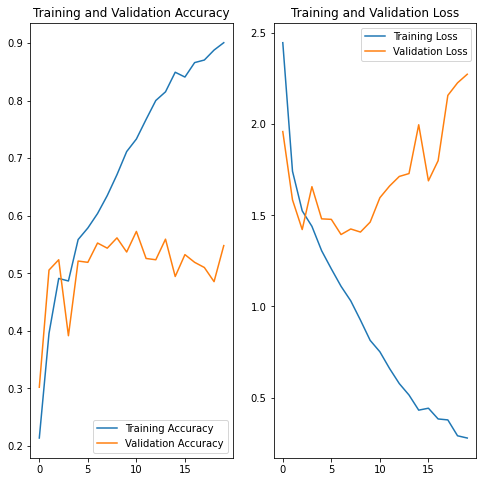

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:  
The base model is overfitting as the training accuracy is high and the validation accuracy is pretty low.

### Class Distribution for the images

In [24]:
c=[]
j=0
for i in class_names:
   c.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
   #print(" Train Dataset Value Counts "+ i + " = " + str(c[i]))


In [27]:
df = pd.DataFrame(data={'class':class_names,'count':c})


,class,count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


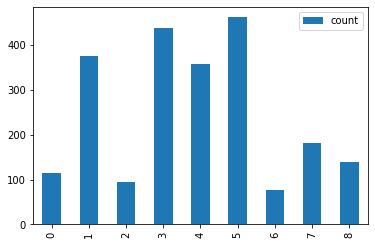

In [29]:
df.plot.bar()
plt.show()

In [57]:
# Now that we have analysed the model fit history for presence of underfit or overfit, let us choose an appropriate data augumentation strategy. 

data_augmentation = tf.keras.Sequential([
                                         layers.RandomFlip("horizontal_and_vertical"),
                                         layers.RandomRotation(0.2),
                                         ])


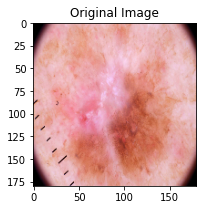

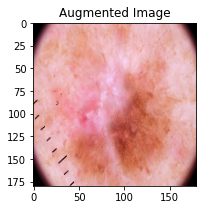

In [58]:
# Visualize how your augmentation strategy works for one instance of training image.

img = tf.keras.preprocessing.image.array_to_img(images[4])
plt.figure(figsize=(3,3))
plt.title("Original Image")
plt.imshow(img)
plt.show()

plt.figure(figsize=(3,3))
aug_image = data_augmentation(images[4])
img1 = tf.keras.preprocessing.image.array_to_img(aug_image)
plt.title("Augmented Image")
plt.imshow(img1)
plt.show()

### Model #2 
### Adding a Dropout layer as there is evidence of overfitting in our Base model


In [59]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9 
model = Sequential([data_augmentation,
                    layers.Dropout(.2),
                    layers.Rescaling(scale=1./255,input_shape = (180,180,3)),
                    layers.Conv2D(16,3,padding='same',activation='relu'),
                    layers.MaxPool2D(pool_size=(2,2)),
                    layers.Conv2D(32,3,padding='same',activation='relu'),
                    layers.MaxPool2D(pool_size=2,strides=2),
                    layers.Flatten(),
                    layers.Dense(128,activation='relu'),
                    layers.Dense(num_classes,activation='softmax')
                    ])

### Compiling the model

In [60]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (180, 180, 3)             0         
                                                                 
 dropout_3 (Dropout)         (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                     

### Training the model

In [62]:
## Train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 125s 2s/step - loss: 3.6498 - accuracy: 0.1931 - val_loss: 2.2448 - val_accuracy: 0.2103
Epoch 2/20
56/56 [==============================] - 55s 989ms/step - loss: 1.9821 - accuracy: 0.2567 - val_loss: 2.3311 - val_accuracy: 0.2215
Epoch 3/20
56/56 [==============================] - 55s 989ms/step - loss: 1.7885 - accuracy: 0.3583 - val_loss: 4.0844 - val_accuracy: 0.1946
Epoch 4/20
56/56 [==============================] - 57s 1s/step - loss: 1.6244 - accuracy: 0.4174 - val_loss: 4.8392 - val_accuracy: 0.1946
Epoch 5/20
56/56 [==============================] - 57s 1s/step - loss: 1.6245 - accuracy: 0.4180 - val_loss: 4.0865 - val_accuracy: 0.1946
Epoch 6/20
56/56 [==============================] - 55s 987ms/step - loss: 1.5737 - accuracy: 0.4414 - val_loss: 4.8834 - val_accuracy: 0.1723
Epoch 7/20
56/56 [==============================] - 55s 984ms/step - loss: 1.5361 - accuracy: 0.4710 - val_loss: 5.7364 - val_accuracy: 0.1969
Epoch 8

In [ ]:
model.summary()

### Visualizing the results

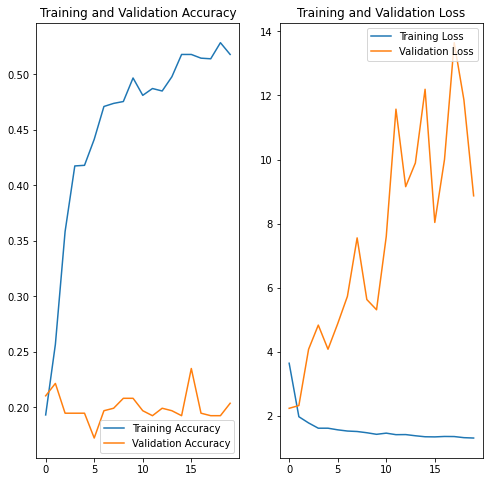

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Ans) There is a pretty high disparity between the tranining accuracy and the test accuracy and there is no real improvement with this data augmentation layer. The model is overfitting.**



#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
### Training Class Distribution 

c=[]
j=0
for i in class_names:
   c.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
df = pd.DataFrame(data={'class':class_names,'count':c})
df

,class,count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


####  Write your findings here: 
#### - Which class has the least number of samples?

**Answer) "seborrheic keratosis" class has the least number of samples**

#### - Which classes dominate the data in terms proportionate number of samples?

**Answer) "pigmented benign keratosis"  class dominates the dataset with higher number of samples.**

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [13]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [16]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset)+ "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Malenoma_Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8DDBCD1A10>: 100%|██████████| 500/500 [00:18<00:00, 26.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Malenoma_Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8DDBC16050>: 100%|██████████| 500/500 [00:18<00:00, 26.45 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Malenoma_Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8DD0052A50>: 100%|██████████| 500/500 [00:18<00:00, 27.16 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Malenoma_Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F8DDBC4CE10>: 100%|██████████| 500/500 [01:22<00:00,  6.07 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Malenoma_Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8DDBC9E310>: 100%|██████████| 500/500 [01:19<00:00,  6.29 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Malenoma_Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8DDBC81510>: 100%|██████████| 500/500 [00:18<00:00, 27.39 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Malenoma_Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8DDBC2D5D0>: 100%|██████████| 500/500 [00:41<00:00, 12.17 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Malenoma_Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8DDBC16B10>: 100%|██████████| 500/500 [00:19<00:00, 26.13 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Malenoma_Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8DDBC6E650>: 100%|██████████| 500/500 [00:18<00:00, 27.07 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [17]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
from glob import glob

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [36]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [37]:
df_new = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [39]:
### Get the path Names and lesion names for origianl list
path_list = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
lesion_list = [os.path.basename((os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [42]:
dataframe_dict = dict(zip(path_list, lesion_list))
orig_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [43]:
### Distribution of the images as per the original dataset

orig_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [38]:
### Augmented samples added to each category 
df_new['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

In [44]:
#### Final training dataset distribution after adding the Augmented data. 
new_df = orig_df.append(df_new)
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [49]:
new_df.shape

(6739, 2)

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [59]:
data_dir_train

PosixPath('/content/gdrive/My Drive/Malenoma_Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [60]:
train_ds1 = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [63]:
val_ds1 = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [62]:
 num_classes = 9 
model = Sequential([
                    layers.Rescaling(scale=1./255,input_shape = (180,180,3)),
                    layers.Conv2D(16,3,padding='same',activation='relu'),
                    layers.MaxPool2D(pool_size=(2,2)),
                    layers.Conv2D(32,3,padding='same',activation='relu'),
                    layers.MaxPool2D(pool_size=2,strides=2),
                    layers.Flatten(),
                    layers.Dense(128,activation='relu'),
                    layers.Dense(num_classes,activation='softmax')
                    ])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [65]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])


#### **Todo:**  Train your model

In [67]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds1,
  validation_data=val_ds1,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 29s 168ms/step - loss: 1.9996 - accuracy: 0.2435 - val_loss: 1.8389 - val_accuracy: 0.2702
Epoch 2/30
169/169 [==============================] - 30s 174ms/step - loss: 1.5713 - accuracy: 0.4097 - val_loss: 1.4057 - val_accuracy: 0.4981
Epoch 3/30
169/169 [==============================] - 29s 166ms/step - loss: 1.2899 - accuracy: 0.5234 - val_loss: 1.2407 - val_accuracy: 0.5405
Epoch 4/30
169/169 [==============================] - 30s 169ms/step - loss: 1.1081 - accuracy: 0.5925 - val_loss: 1.2067 - val_accuracy: 0.5768
Epoch 5/30
169/169 [==============================] - 29s 167ms/step - loss: 0.9693 - accuracy: 0.6504 - val_loss: 1.1292 - val_accuracy: 0.6244
Epoch 6/30
169/169 [==============================] - 29s 168ms/step - loss: 0.8262 - accuracy: 0.7077 - val_loss: 1.1244 - val_accuracy: 0.6102
Epoch 7/30
169/169 [==============================] - 29s 166ms/step - loss: 0.6973 - accuracy: 0.7559 - val_loss: 1.0114 - val_ac

#### **Todo:**  Visualize the model results

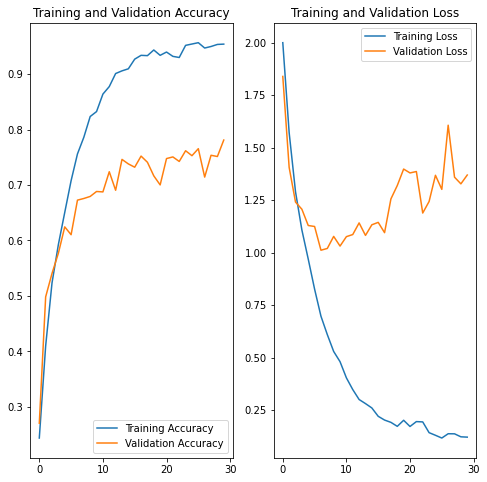

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Ans)**After the class rebalance the model overfitting/underfitting issues got addresssed and the model training and validation accuracy also imrpoved.